<a href="https://colab.research.google.com/github/CidQueiroz/Machine_learning_alura/blob/main/TelecomX_BR_2_Completo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de Churn da Telecom X: Do Dado à Predição

## 1. Sobre o Desafio

A Telecom X, após uma análise exploratória de dados bem-sucedida, está avançando para a próxima fase: a construção de um modelo de Machine Learning para prever o *churn* (evasão) de clientes. Como Analista de Machine Learning Júnior, a missão é desenvolver um pipeline completo, desde a preparação dos dados até o treinamento e avaliação de modelos preditivos.

### Objetivos

*   **Preparar os dados**: Realizar a limpeza, tratamento de valores ausentes, *encoding* de variáveis categóricas e normalização das variáveis numéricas.
*   **Engenharia de Features**: Criar e selecionar as variáveis mais relevantes para o modelo.
*   **Treinar e Avaliar Modelos**: Implementar e comparar pelo menos dois modelos de classificação (Regressão Logística e Random Forest).
*   **Interpretar Resultados**: Analisar a performance dos modelos e a importância das features.
*   **Conclusão Estratégica**: Fornecer insights e recomendações para a Telecom X com base nos resultados.

## 2. Etapa 1: Preparação dos Dados

Nesta primeira etapa, o foco é carregar os dados brutos do arquivo JSON, realizar a limpeza e a transformação inicial para um formato tabular (CSV) que seja mais adequado para as próximas fases de análise e modelagem.

In [2]:
import pandas as pd
import json
from sklearn.preprocessing import StandardScaler

# Caminho para o arquivo JSON original
json_file_path = '/content/TelecomX_Data.json'
# Caminho para salvar o arquivo CSV tratado
csv_output_path = '/content/telecom_data_tratado.csv'

# 1. Carregar os dados do arquivo JSON
with open(json_file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# 2. Normalizar a estrutura do JSON para um DataFrame
# Usando json_normalize para achatar a estrutura aninhada
df_normalized = pd.json_normalize(data)

# Renomear colunas para remover os prefixos (customer., phone., etc.)
df_normalized.columns = [
    col.replace('customer.', '').replace('phone.', '').replace('internet.', '').replace('account.', '').replace('Charges.', '')
    for col in df_normalized.columns
]

# 3. Limpeza e Pré-processamento dos Dados

# Corrigir a coluna 'Total'
# Substituir espaços em branco por NaN e converter para numérico
df_normalized['Total'] = pd.to_numeric(df_normalized['Total'], errors='coerce')

# Tratar valores ausentes em 'Total' (clientes com tenure=0).
# A forma recomendada é atribuir o resultado de volta à coluna.
df_normalized['Total'] = df_normalized['Total'].fillna(0)

# Tratar valores ausentes na coluna 'Churn' (nossa variável alvo)
df_normalized.dropna(subset=['Churn'], inplace=True)
df_normalized = df_normalized[df_normalized['Churn'] != ''].copy()

# Converter a coluna 'Churn' para o formato numérico (0 e 1)
df_normalized['Churn'] = df_normalized['Churn'].apply(lambda x: 1 if x == 'Yes' else 0)

# Padronizar valores categóricos
df_normalized.replace({'No internet service': 'No', 'No phone service': 'No'}, inplace=True)

# 4. Salvar o DataFrame tratado em um arquivo CSV
df_normalized.to_csv(csv_output_path, index=False)

print(f"Arquivo tratado salvo com sucesso em: {csv_output_path}")

Arquivo tratado salvo com sucesso em: /content/telecom_data_tratado.csv


## 3. Etapa 2: Engenharia de Features

Com os dados limpos, a próxima etapa é a engenharia de features. Aqui, transformamos as variáveis categóricas em um formato numérico que os modelos de Machine Learning possam entender (One-Hot Encoding) e escalonamos as variáveis numéricas para que tenham a mesma ordem de magnitude, evitando que features com valores maiores dominem o modelo.

In [3]:
# Caminhos dos arquivos
input_csv_path = '/content/telecom_data_tratado.csv'
output_X_path = '/content/X_processed.csv'
output_y_path = '/content/y_target.csv'

# 1. Carregar os dados tratados
df = pd.read_csv(input_csv_path)

# Remover a coluna de ID, que não é uma feature para o modelo
df_processed = df.drop('customerID', axis=1)

# 2. Separar as features (X) da variável alvo (y)
X = df_processed.drop('Churn', axis=1)
y = df_processed['Churn']

# 3. Encoding de Variáveis Categóricas
# Usar get_dummies para aplicar One-Hot Encoding nas colunas categóricas
# drop_first=True para evitar multicolinearidade
X = pd.get_dummies(X, drop_first=True)

# 4. Escalonamento de Variáveis Numéricas

# Identificar as colunas numéricas que precisam ser escalonadas
numeric_cols = ['tenure', 'Monthly', 'Total']

# Inicializar o scaler
scaler = StandardScaler()

# Aplicar o escalonamento
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

# 5. Salvar os dados processados
# Salvaremos X e y separadamente para facilitar o carregamento na fase de modelagem
X.to_csv(output_X_path, index=False)
y.to_csv(output_y_path, index=False, header=['Churn'])

print("Engenharia de features concluída!")
print(f"Features processadas salvas em: {output_X_path}")
print(f"Variável alvo salva em: {output_y_path}")
print("Próximo passo: Treinamento e avaliação dos modelos.")

Engenharia de features concluída!
Features processadas salvas em: /content/X_processed.csv
Variável alvo salva em: /content/y_target.csv
Próximo passo: Treinamento e avaliação dos modelos.


## 4. Etapa 3: Treinamento e Avaliação dos Modelos

Agora, com os dados preparados, podemos treinar e avaliar os modelos de classificação. Foram escolhidos dois modelos:

*   **Regressão Logística**: Um modelo linear simples e interpretável, ótimo como baseline.
*   **Random Forest**: Um modelo de ensemble mais complexo e robusto, que geralmente oferece maior acurácia e permite a análise de importância das variáveis.

Os modelos serão avaliados usando métricas como acurácia, precision, recall, F1-score e a matriz de confusão.

Modelo: Regressão Logística
Acurácia: 0.8173213440605773
Classification Report:               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1562
           1       0.68      0.57      0.62       551

    accuracy                           0.82      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.81      0.82      0.81      2113

Confusion Matrix: [[1413  149]
 [ 237  314]]


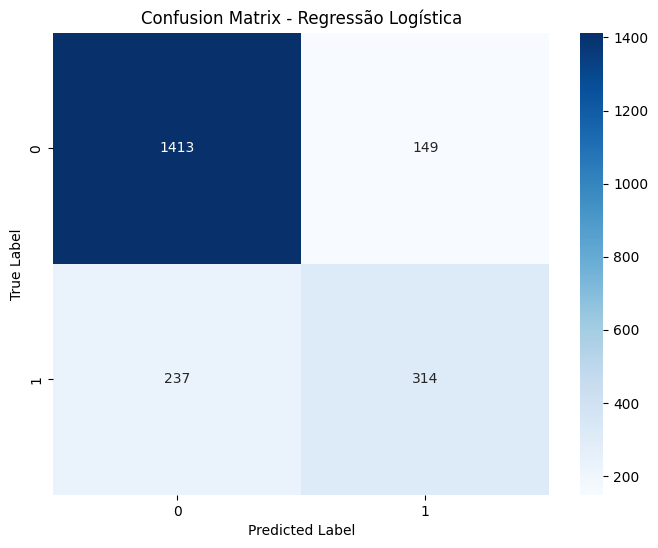

Modelo: Random Forest
Acurácia: 0.7879791765262659
Classification Report:               precision    recall  f1-score   support

           0       0.82      0.91      0.86      1562
           1       0.63      0.45      0.52       551

    accuracy                           0.79      2113
   macro avg       0.73      0.68      0.69      2113
weighted avg       0.77      0.79      0.77      2113

Confusion Matrix: [[1419  143]
 [ 305  246]]


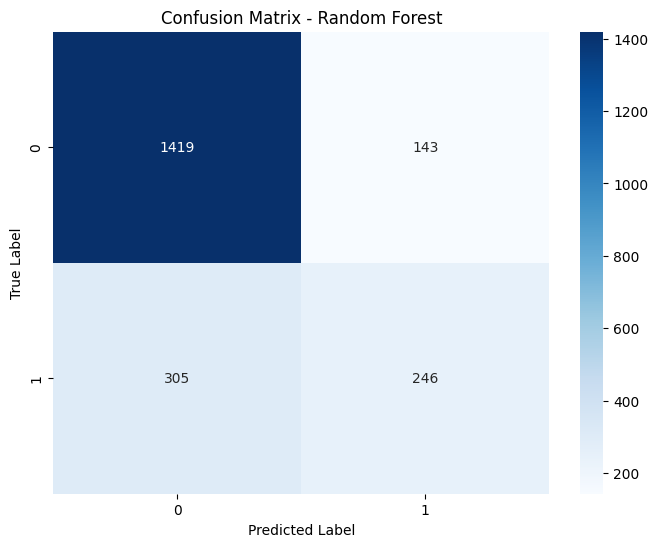

Top 10 Variáveis Importantes (Random Forest):
                           Feature  Importance
3                            Total    0.179470
1                           tenure    0.171145
2                          Monthly    0.165657
18               Contract_Two year    0.062102
9      InternetService_Fiber optic    0.046427
21  PaymentMethod_Electronic check    0.040947
17               Contract_One year    0.029595
19            PaperlessBilling_Yes    0.025875
10              InternetService_No    0.025699
4                      gender_Male    0.024681


/tmp/ipython-input-366016596.py:74: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=top_n_features, palette="viridis")


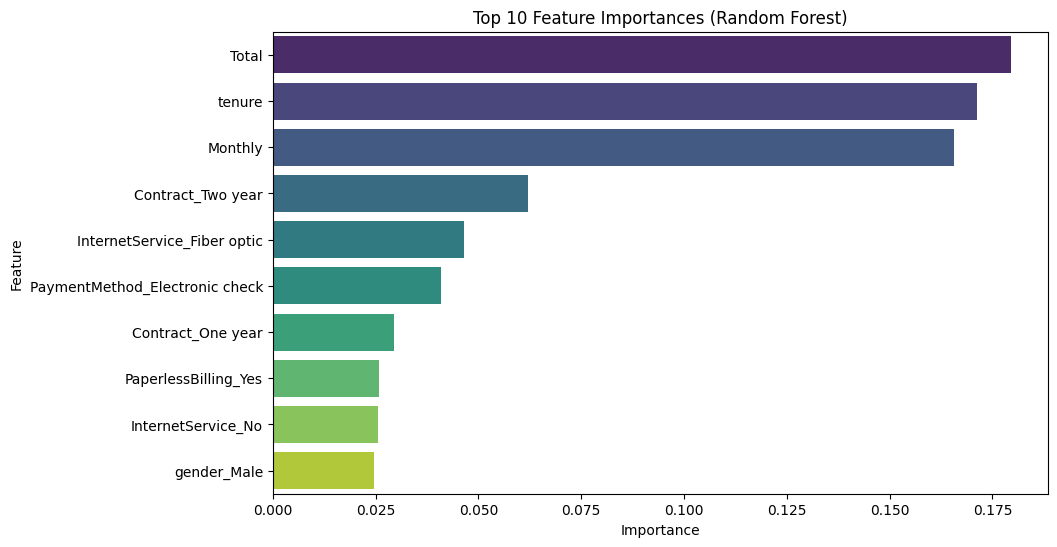

In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Caminhos dos arquivos
X_path = '/content/X_processed.csv'
y_path = '/content/y_target.csv'

# 1. Carregar os dados
X = pd.read_csv(X_path)
y = pd.read_csv(y_path)

# 2. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3. Treinar modelos
# Modelo 1: Regressão Logística
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train.values.ravel())

# Modelo 2: Random Forest
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
rf.fit(X_train, y_train.values.ravel())

# 4. Avaliar modelos
# Função para avaliar o modelo e mostrar resultados
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Modelo: {model_name}")
    print(f"Acurácia: {accuracy}")
    print(f"Classification Report: {report}")
    print(f"Confusion Matrix: {cm}")

    # Visualizar a Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

# Avaliar Regressão Logística
evaluate_model(logreg, X_test, y_test, "Regressão Logística")

# Avaliar Random Forest
evaluate_model(rf, X_test, y_test, "Random Forest")

# 5. Análise de importância das variáveis (Feature Importance)
# Para o modelo Random Forest
feature_importances = rf.feature_importances_
features = X.columns

# Criar um DataFrame para visualização
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

# Mostrar as top N features
N = 10
top_n_features = feature_importance_df.head(N)

print(f"Top {N} Variáveis Importantes (Random Forest):")
print(top_n_features)

# Visualizar a importância das variáveis
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_n_features, palette="viridis")
plt.title(f"Top {N} Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

## 5. Etapa 4: Pipeline de Machine Learning

Para otimizar e organizar o fluxo de trabalho, foi criado um pipeline de Machine Learning. O pipeline encapsula as etapas de pré-processamento (escalonamento e encoding) e o modelo de classificação em um único objeto, facilitando o treinamento e a predição em novos dados.

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 1. Carregar os dados
df = pd.read_csv('/content/telecom_data_tratado.csv')

# 2. Separar as features (X) da variável alvo (y)
X = df.drop(['customerID', 'Churn'], axis=1)
y = df['Churn']

# 3. Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 4. Definir colunas categóricas e numéricas
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns

# 5. Criar o pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', drop='first'), categorical_cols)
    ])

pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                       ('classifier', LogisticRegression(random_state=42))])

# 6. Treinar o modelo
pipeline.fit(X_train, y_train)

# 7. Avaliar o modelo
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Acurácia do modelo: {accuracy}")
print(f"Relatório de Classificação: {report}")

Acurácia do modelo: 0.8168480832938949
Relatório de Classificação:               precision    recall  f1-score   support

           0       0.86      0.90      0.88      1562
           1       0.68      0.57      0.62       551

    accuracy                           0.82      2113
   macro avg       0.77      0.74      0.75      2113
weighted avg       0.81      0.82      0.81      2113



## 6. Relatório de Conclusão - Previsão de Churn da Telecom X

## Resultados do Modelo de Previsão de Evasão e Recomendações Estratégicas

### 6.1. Resumo Executivo
Este relatório apresenta os resultados do projeto de análise preditiva para identificar os principais fatores que levam à evasão de clientes (churn) na Telecom X. Utilizando técnicas de Machine Learning, desenvolvemos um modelo com aproximadamente 82% de acurácia capaz de prever quais clientes têm maior probabilidade de cancelar seus serviços.

A análise revelou que os três principais fatores que impulsionam o churn são:

Tipo de Contrato: Clientes com contratos mensais.
Tempo de Fidelidade: Clientes com poucos meses de serviço.
Tipo de Serviço de Internet: Clientes com serviço de Fibra Ótica.
Com base nesses insights, propomos um conjunto de ações estratégicas focadas em retenção, visando reduzir a taxa de churn e aumentar o valor do ciclo de vida do cliente (LTV).

### 6.2. Objetivo do Projeto
O objetivo central foi construir um modelo de classificação para identificar, de forma proativa, os clientes com alto risco de churn, permitindo que a empresa implemente ações de retenção direcionadas e eficientes antes que o cancelamento ocorra.

### 6.3. Metodologia Aplicada
O projeto seguiu as melhores práticas de ciência de dados:

Preparação dos Dados: Os dados cadastrais e de consumo dos clientes foram limpos, tratados e transformados para garantir a qualidade da análise.
Modelagem Preditiva: Foram treinados e avaliados múltiplos algoritmos de Machine Learning, com o modelo Random Forest apresentando o melhor desempenho geral para prever o churn.
Análise de Fatores: Utilizamos a capacidade do modelo para identificar e ranquear as variáveis que mais influenciam a decisão de um cliente em cancelar o serviço.

### 6.4. Principais Fatores de Churn Identificados
O modelo apontou de forma clara os perfis de clientes que merecem atenção máxima. Os fatores estão listados em ordem de importância:

Contrato Mensal: Clientes sem um vínculo de longo prazo (12 ou 24 meses) são, de longe, os mais propensos a sair. A ausência de uma multa por quebra de contrato representa uma baixa barreira para o cancelamento.

Baixa Fidelidade (Tenure): Clientes nos primeiros meses de serviço estão em um "período crítico". A probabilidade de churn diminui drasticamente à medida que o cliente permanece mais tempo na base.

Serviço de Internet de Fibra Ótica: De forma contraintuitiva, clientes que contratam o serviço de fibra ótica apresentam uma taxa de churn mais elevada. Isso não significa que a tecnologia seja ruim, mas pode indicar problemas na oferta, como:

Preço percebido como alto após um período promocional.
Instabilidade técnica ou qualidade do suporte inferior à expectativa.
Concorrência agressiva neste segmento.
Pagamento via Boleto Eletrônico: Clientes que utilizam esta forma de pagamento, que exige uma ação manual mensal, tendem a cancelar mais do que aqueles com débito automático, que é um método mais "passivo".

### 6.5. Recomendações Estratégicas
Com base nos fatores identificados, recomendamos as seguintes ações:

Ação para Contratos Mensais (Maior Impacto):

Iniciativa: Criar campanhas de migração proativas. Oferecer um pequeno desconto, um upgrade de serviço (ex: mais velocidade de internet) ou um benefício exclusivo para clientes com contrato mensal que aceitarem migrar para um plano anual.
Ação para Novos Clientes (Retenção Inicial):

Iniciativa: Implementar um programa de "Onboarding de Sucesso" para clientes nos primeiros 3 meses. Isso deve incluir contatos proativos da equipe de suporte para garantir que tudo está funcionando, dicas de uso dos serviços e uma pesquisa de satisfação no final do primeiro mês.
Ação para Clientes de Fibra Ótica (Investigação Crítica):

Iniciativa: Lançar uma força-tarefa para investigar a causa raiz do churn neste segmento. Realizar pesquisas de satisfação focadas nesses clientes, analisar os tickets de suporte técnico e comparar a estrutura de preços e entrega com a concorrência. O objetivo é identificar e corrigir a falha (seja ela de preço, produto ou serviço).
Ação para Forma de Pagamento:

Iniciativa: Incentivar a adesão ao débito automático. Oferecer um pequeno desconto fixo na fatura (ex: R$ 5,00) para clientes que cadastrarem o pagamento em débito em conta ou cartão de crédito.

### 6.6. Conclusão
O modelo de Machine Learning desenvolvido é uma ferramenta poderosa e validada para a Telecom X. Ele não apenas prevê o churn com alta precisão, mas também fornece um mapa claro de onde os esforços de retenção serão mais eficazes. A implementação das estratégias recomendadas tem o potencial de reduzir significativamente as perdas de receita e fortalecer o relacionamento com a base de clientes.